In [1]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from contextlib import contextmanager
from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

Using TensorFlow backend.


In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
CRAWL_EMBEDDING_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'
NUM_MODELS = 2
LSTM_UNITS = 128
MAX_LEN = 220

In [4]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [5]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

In [8]:
# 8.9G
with timer('crawl'):
    crawl_emb_dict = load_embeddings(CRAWL_EMBEDDING_PATH)
gc.collect()

[crawl] done in 92 s


224

In [10]:
%%time
# 9.9G
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

x_train = train['comment_text']
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = test['comment_text']
del train, test
gc.collect()

CPU times: user 8.7 s, sys: 584 ms, total: 9.28 s
Wall time: 8.05 s


In [11]:
x_train.shape, y_train.shape, y_aux_train.shape, x_test.shape

((1804874,), (1804874,), (1804874, 6), (97320,))

0

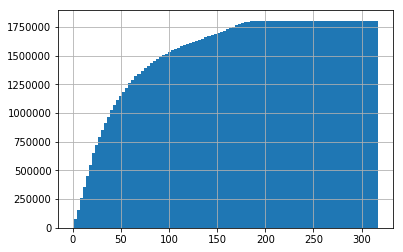

In [12]:
# とりあえず100とかでいいやろう
x_train.fillna("").apply(lambda x: len(x.split())).hist(bins=100, cumulative=True)
gc.collect()

In [13]:
def head(enumerable, n):
    for i, item in enumerate(enumerable):
        print(str(i) + '\n' + item)
        if i > n:
            return

In [14]:
# このShittyとかをどうにかしたいな
head(x_train, 5)

0
This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!
1
Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!
2
This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3
Is this something I'll be able to install on my site? When will you be releasing it?
4
haha you guys are a bunch of losers.
5
ur a sh*tty comment.
6
hahahahahahahahhha suck it.


In [15]:
crawl_emb_dict['b*tch']

KeyError: 'b*tch'

In [16]:
head(x_train[y_train == 1], 5)

0
haha you guys are a bunch of losers.
1
ur a sh*tty comment.
2
It's ridiculous that these guys are being called "protesters". Being armed is a threat of violence, which makes them terrorists.
3
This story gets more ridiculous by the hour! And, I love that people are sending these guys dildos in the mail now. But… if they really think there's a happy ending in this for any of them, I think they're even more deluded than all of the jokes about them assume.
4
Angry trolls, misogynists and Racists", oh my. It doesn't take all of my 150 IQ to see the slant here.  it's the "Diversity diode" at work yet again. "We can say anything that we want because we are Diversity. You on the other hand must only  say what we allow you to say. From now on, winning arguments against any member of diversity will be considered offensive language.  facts, cogent, linear posts and Math are now verboten.
5
Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an en

In [17]:
import re
# これだと、'はembeddingに結構入ってるのに除外されちゃう。　よくないので ' だけ抜いた
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x: str) -> str:
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' {} '.format(punct))
    return x

puncts_apos = ["''", ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x: str) -> str:
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' {} '.format(punct))
    return x

def clean_text_apos(x: str) -> str:
    for punct in puncts_apos:
        if punct in x:
            x = x.replace(punct, ' {} '.format(punct))
    return x

def clean_numbers_space(x: str) -> str:
    x = re.sub('[0-9]{5,}', ' ##### ', x)
    x = re.sub('[0-9]{4}', ' #### ', x)
    x = re.sub('[0-9]{3}', ' ### ', x)
    x = re.sub('[0-9]{2}', ' ## ', x)
    return x


In [18]:
import operator
from typing import Dict, List
def build_vocab(texts: pd.DataFrame) -> Dict[str, int]:
    """
    
    Parameters
    -----
    texts: pandas.Series
        question textの列
        
    Returns
    -----
    dict: 
        単語とカウント
    
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab: Dict[str, int], embeddings_index: Dict) -> List[str]:
    """
    Parameters
    -----
    vocab: dict
        単語とカウント
    embeddings_index: dict
        load_embedの出力
        
    Returns:
        list:
            embeddingsに入ってない単語
    """
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / float(len(vocab))))
    print('Found embeddings for  {:.2%} of all text'.format(float(nb_known_words) / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [19]:
from nltk.stem import PorterStemmer
p_stemmer = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
l_stemmer = LancasterStemmer()
from nltk.stem import SnowballStemmer
s_stemmer = SnowballStemmer("english")

In [20]:
import copy
def edits1(word):
    """
    wordの編集距離1の単語のリストを返す
    """
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def known(words, embed): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in embed)

def spellcheck(word, word_rank_dict):
    return min(known(edits1(word), word_rank_dict), key=lambda w: word_rank_dict[w])


punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }
def process_stemmer(vocab, embed):
    
    oov_word_set = set()
    for word in vocab.keys():
        vector = embed.get(word, None)
        if vector is not None:
            continue

        vector = embed.get(word.lower(), None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(word.upper(), None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(word.capitalize(), None)
        if vector is not None:
            embed[word] = vector
            continue
            
        corr_word = punct_mapping.get(word, None)
        if corr_word is not None:
            vector = embed.get(corr_word, None)
            if vector is not None:
                embed[word] = vector
                continue
        
        try:
            vector = embed.get(p_stemmer.stem(word), None)
        except:
            vector = embed.get(p_stemmer.stem(word.decode('utf-8')), None)
        if vector is not None:
            embed[word] = vector
            continue
            
        try:
            vector = embed.get(l_stemmer.stem(word), None)
        except:
            vector = embed.get(l_stemmer.stem(word.decode('utf-8')), None)
        if vector is not None:
            embed[word] = vector
            continue
        
        try:
            vector = embed.get(s_stemmer.stem(word), None)
        except:
            vector = embed.get(s_stemmer.stem(word.decode('utf-8')), None)
        
        char_list = []
        for char in word:
            if 'LATIN LETTER SMALL CAPITAL' in char:
                
            
        if vector is not None:
            embed[word] = vector
            continue
        

        oov_word_set.add(word)
            
    return embed, oov_word_set

def process_spellcheck(vocab, embed, word_rank_dict, oov_set):
    for word in vocab.keys():
        if word not in oov_set:
            continue
            
        try:
            vector = embed.get(spellcheck(word, word_rank_dict), None)
        except:
            continue
        if vector is not None:
            embed[word] = vector
            continue
            
    return embed

def make_word_rank(embed):
    word_rank = {}
    for i, word in enumerate(embed):
        word_rank[word] = i
    return word_rank

In [21]:
concat_desc = pd.concat([x_train, x_test], ignore_index=True).fillna("")

In [22]:
concat_desc.shape

(1902194,)

In [23]:
%%time
processed_concat_desc = concat_desc.apply(lambda x: clean_text(x))
processed_concat_desc = processed_concat_desc.apply(lambda x: clean_numbers_space(x))

CPU times: user 51.5 s, sys: 300 ms, total: 51.8 s
Wall time: 51.8 s


In [24]:
vocab = build_vocab(processed_concat_desc)

In [25]:
gc.collect()

0

In [26]:
len(vocab)

461012

In [27]:
%%time
oov_p = check_coverage(vocab, crawl_emb_dict)

Found embeddings for 53.78% of vocab
Found embeddings for  98.29% of all text
CPU times: user 358 ms, sys: 12 ms, total: 370 ms
Wall time: 368 ms


In [29]:
type(oov_p)

list

In [30]:
oov_p[:5]

[('##', 423979),
 ('###', 173275),
 ('####', 161039),
 ('_', 65327),
 ("Trump's", 25361)]

In [33]:
%%time
processed_concat_desc = concat_desc.apply(lambda x: clean_text(x))

CPU times: user 12.1 s, sys: 7.95 ms, total: 12.1 s
Wall time: 12.1 s


In [34]:
del vocab
gc.collect()

3276

In [35]:
vocab = build_vocab(processed_concat_desc)

In [36]:
len(vocab)

482096

In [37]:
%%time
oov_p = check_coverage(vocab, crawl_emb_dict)

Found embeddings for 53.24% of vocab
Found embeddings for  98.91% of all text
CPU times: user 363 ms, sys: 4.09 ms, total: 367 ms
Wall time: 366 ms


In [39]:
oov_p[:100]

[('_', 65327),
 ("Trump's", 25361),
 ("aren't", 22714),
 ("Don't", 21779),
 ("wouldn't", 21158),
 ("wasn't", 19896),
 ("You're", 14954),
 ("Let's", 14817),
 ("He's", 12654),
 ("couldn't", 12060),
 ("There's", 11290),
 ("let's", 10409),
 ("what's", 10359),
 ("shouldn't", 10267),
 ("hasn't", 8539),
 ("What's", 8478),
 ("Canada's", 8409),
 ("you've", 8138),
 ('`', 7591),
 ("weren't", 6634),
 ("Here's", 6307),
 ("Obama's", 6232),
 ("They're", 5807),
 ("one's", 5607),
 ("people's", 5597),
 ("you'd", 5440),
 ("we'll", 5293),
 ("they've", 5179),
 ("We're", 5156),
 ("Can't", 4993),
 ("they'll", 4990),
 ("we've", 4944),
 ("today's", 4798),
 ("Trudeau's", 4645),
 ("who's", 4599),
 ("Isn't", 4441),
 ("Alaska's", 4127),
 ("God's", 3650),
 ("he'll", 3471),
 ("ain't", 3241),
 ("women's", 3182),
 ("Didn't", 3120),
 ("Doesn't", 3119),
 ("they'd", 3073),
 ("She's", 3060),
 ("world's", 3032),
 ("America's", 2962),
 ("he'd", 2908),
 ("Clinton's", 2901),
 ("You've", 2833),
 ("We've", 2758),
 ("else's", 25

In [40]:
%%time
crawl_emb_dict, oov_glove = process_stemmer(vocab, crawl_emb_dict)
word_rank_glove = make_word_rank(crawl_emb_dict)

CPU times: user 8.63 s, sys: 40.1 ms, total: 8.67 s
Wall time: 8.67 s


In [41]:
%%time
oov_g = check_coverage(vocab, process_spellcheck(vocab, crawl_emb_dict, word_rank_glove, oov_glove))

Found embeddings for 84.33% of vocab
Found embeddings for  99.86% of all text


In [42]:
oov_g[:100]

[('theglobeandmail', 1420),
 ('ᴀɴᴅ', 540),
 ('nationalpost', 438),
 ('2gTbpns', 381),
 ('ᴛʜᴇ', 371),
 ('ʜᴏᴍᴇ', 358),
 ('ᴜᴘ', 357),
 ('Yᴏᴜ', 356),
 ('denverpost', 339),
 ('civilbeat', 285),
 ('RangerMC', 276),
 ('garycrum', 266),
 ('BCLibs', 260),
 ('cashapp24', 237),
 ('dailycaller', 217),
 ('washingtontimes', 210),
 ('Cheetolini', 203),
 ('Tridentinus', 201),
 ('ᴄʜᴇᴄᴋ', 194),
 ('ғᴏʀ', 191),
 ('ᴄᴏᴍᴘᴜᴛᴇʀ', 190),
 ('ᴛʜɪs', 188),
 ('ᴍᴏɴᴛʜ', 186),
 ('ᴡᴏʀᴋɪɴɢ', 185),
 ('Ontariowe', 184),
 ('ᴊᴏʙ', 184),
 ('ᴏғ', 184),
 ('ʜᴏᴜʀʟʏ', 184),
 ('ᴡᴇᴇᴋ', 180),
 ('ʟɪɴᴋ', 180),
 ('financialpost', 179),
 ('ʜᴀᴠᴇ', 179),
 ('ᴄᴀɴ', 179),
 ('MAGAphants', 178),
 ('ᴇɴᴅ', 178),
 ('ғɪʀsᴛ', 178),
 ('ʏᴏᴜʀ', 178),
 ('sɪɢɴɪɴɢ', 178),
 ('ʙᴏᴛᴛᴏᴍ', 178),
 ('ғᴏʟʟᴏᴡɪɴɢ', 178),
 ('Mᴀᴋᴇ', 178),
 ('ᴄᴏɴɴᴇᴄᴛɪᴏɴ', 178),
 ('ɪɴᴛᴇʀɴᴇᴛ', 178),
 ('ʀᴇʟɪᴀʙʟᴇ', 178),
 ('ɴᴇᴇᴅ', 178),
 ('ᴏɴʟʏ', 178),
 ('ɪɴᴄᴏᴍᴇ', 178),
 ('ᴇxᴛʀᴀ', 178),
 ('ɴᴇᴇᴅɪɴɢ', 178),
 ('ᴀɴʏᴏɴᴇ', 178),
 ('ᴍᴏᴍs', 178),
 ('sᴛᴀʏ', 178),
 ('sᴛᴜᴅᴇɴᴛs', 178),
 ('Gʀᴇᴀᴛ', 178)

In [44]:
import unicodedata

In [53]:
unicodedata.name('ᴛ')[-1]

'T'

In [46]:
unicodedata.name('Y')

'LATIN CAPITAL LETTER Y'

In [47]:
unicodedata.name('ᴏ')

'LATIN LETTER SMALL CAPITAL O'

In [51]:
unicodedata.normalize('NFC', 'ᴛʜɪs')

'ᴛʜɪs'

In [81]:
import unicodedata
def process_stemmer(vocab, embed):
    
    oov_word_set = set()
    for word in vocab.keys():
        vector = embed.get(word, None)
        if vector is not None:
            continue

        vector = embed.get(word.lower(), None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(word.upper(), None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(word.capitalize(), None)
        if vector is not None:
            embed[word] = vector
            continue
            
        corr_word = punct_mapping.get(word, None)
        if corr_word is not None:
            vector = embed.get(corr_word, None)
            if vector is not None:
                embed[word] = vector
                continue
        
        try:
            vector = embed.get(p_stemmer.stem(word), None)
        except:
            vector = embed.get(p_stemmer.stem(word.decode('utf-8')), None)
        if vector is not None:
            embed[word] = vector
            continue
            
        try:
            vector = embed.get(l_stemmer.stem(word), None)
        except:
            vector = embed.get(l_stemmer.stem(word.decode('utf-8')), None)
        if vector is not None:
            embed[word] = vector
            continue
        
        try:
            vector = embed.get(s_stemmer.stem(word), None)
        except:
            vector = embed.get(s_stemmer.stem(word.decode('utf-8')), None)
                    
        if vector is not None:
            embed[word] = vector
            continue
            
        char_list = []
        any_small_capitial = False
        for char in word:
            try:
                uni_name = unicodedata.name(char)
            except ValueError:
                continue
                
            if 'LATIN LETTER SMALL CAPITAL' in uni_name:
                char = uni_name[-1]
                any_small_capitial = True
            if 'CYRILLIC SMALL LETTER GHE WITH STROKE' in uni_name:
                char = 'F'
                any_small_capitial = True
                
            char_list.append(char)
            
        if not any_small_capitial:
            oov_word_set.add(word)
            continue
        
        legit_word = ''.join(char_list)
        
        # 2週目
        
        vector = embed.get(legit_word, None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(legit_word.lower(), None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(legit_word.upper(), None)
        if vector is not None:
            embed[word] = vector
            continue

        vector = embed.get(legit_word.capitalize(), None)
        if vector is not None:
            embed[word] = vector
            continue
            
        corr_word = punct_mapping.get(legit_word, None)
        if corr_word is not None:
            vector = embed.get(corr_word, None)
            if vector is not None:
                embed[word] = vector
                continue
        
        try:
            vector = embed.get(p_stemmer.stem(legit_word), None)
        except:
            vector = embed.get(p_stemmer.stem(legit_word.decode('utf-8')), None)
        if vector is not None:
            embed[word] = vector
            continue
            
        try:
            vector = embed.get(l_stemmer.stem(legit_word), None)
        except:
            vector = embed.get(l_stemmer.stem(legit_word.decode('utf-8')), None)
        if vector is not None:
            embed[word] = vector
            continue
        
        try:
            vector = embed.get(s_stemmer.stem(legit_word), None)
        except:
            vector = embed.get(s_stemmer.stem(legit_word.decode('utf-8')), None)
                    
        if vector is not None:
            embed[word] = vector
            continue

        oov_word_set.add(word)
            
    return embed, oov_word_set

In [85]:
%%time
crawl_emb_dict, oov = process_stemmer(vocab, crawl_emb_dict)
word_rank = make_word_rank(crawl_emb_dict)
crawl_emb_dict = process_spellcheck(vocab, crawl_emb_dict, word_rank, oov)
oov_g = check_coverage(vocab, crawl_emb_dict)

Found embeddings for 85.59% of vocab
Found embeddings for  99.88% of all text
CPU times: user 19.7 s, sys: 32 ms, total: 19.7 s
Wall time: 19.7 s


In [83]:
oov_g[:100]

[('theglobeandmail', 1420),
 ('nationalpost', 438),
 ('2gTbpns', 381),
 ('denverpost', 339),
 ('civilbeat', 285),
 ('RangerMC', 276),
 ('garycrum', 266),
 ('cashapp24', 237),
 ('dailycaller', 217),
 ('washingtontimes', 210),
 ('Cheetolini', 203),
 ('Ontariowe', 184),
 ('financialpost', 179),
 ('MAGAphants', 178),
 ('scientificamerican', 161),
 ('motleycrew', 161),
 ('ncronline', 158),
 ('talkingpointsmemo', 155),
 ('motherjones', 153),
 ('Outsider77', 151),
 ('Putrumpski', 150),
 ('diverdave', 148),
 ('Mahawker', 148),
 ('TheDonald', 140),
 ('antifluoridationists', 140),
 ('staradvertiser', 133),
 ('Lazeelink', 131),
 ('Pandora17', 128),
 ('22moneybay', 125),
 ('Bozievich', 125),
 ('thedailybeast', 122),
 ('skyofblue', 121),
 ('muckamuck', 118),
 ('conservativereview', 115),
 ('americanthinker', 115),
 ('vancouversun', 114),
 ('McWynnety', 114),
 ('jerry69', 113),
 ('torontosun', 111),
 ('politicususa', 109),
 ('antifluoridationist', 107),
 ('seattletimes', 106),
 ("ponokeali'i", 104),

In [87]:
import pickle

In [ ]:
with open('../input/roov-crawl.pickle', )